<a href="https://colab.research.google.com/github/caroidarraga/Aprendizaje_No_Supervisado/blob/main/GAN_condicional_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GAN

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/07/13<br>
**Last modified:** 2021/10/19 by Félix Fuentes (VIU)<br>


In [1]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


## Imports

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio

## Constants and hyperparameters

In [3]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

## Loading the MNIST dataset and preprocessing it

In [4]:
# We'll use all the available examples from both the training and test
# sets.
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

4422102/4422102 [==============================] - 1s 0us/step
Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


## Calculating the number of input channel for the generator and discriminator

In a regular (unconditional) GAN, we start by sampling noise (of some fixed
dimension) from a normal distribution. In our case, we also need to account
for the class labels. We will have to add the number of classes to
the input channels of the generator (noise input) as well as the discriminator
(generated image input).

In [5]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(num_classes, generator_in_channels, discriminator_in_channels)

10 138 11


## Creating the discriminator and generator

The model definitions (`discriminator`, `generator`, and `ConditionalGAN`) have been
adapted from [this example](https://keras.io/guides/customizing_what_happens_in_fit/).

In [6]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

## Creating a `ConditionalGAN` model

In [7]:

class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


## Training the Conditional GAN

In [8]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=20)

Epoch 1/20
1094/1094 [==============================] - 43s 28ms/step - g_loss: 1.5818 - d_loss: 0.4580
Epoch 2/20
1094/1094 [==============================] - 30s 28ms/step - g_loss: 2.1195 - d_loss: 0.2885
Epoch 3/20
1094/1094 [==============================] - 30s 28ms/step - g_loss: 2.2191 - d_loss: 0.2316
Epoch 4/20
1094/1094 [==============================] - 30s 27ms/step - g_loss: 0.8983 - d_loss: 0.6999
Epoch 5/20
1094/1094 [==============================] - 30s 27ms/step - g_loss: 0.8170 - d_loss: 0.6852
Epoch 6/20
1094/1094 [==============================] - 30s 27ms/step - g_loss: 0.8026 - d_loss: 0.6740
Epoch 7/20
1094/1094 [==============================] - 30s 27ms/step - g_loss: 0.8275 - d_loss: 0.6676
Epoch 8/20
1094/1094 [==============================] - 30s 27ms/step - g_loss: 0.9577 - d_loss: 0.6598
Epoch 9/20
1094/1094 [==============================] - 30s 27ms/step - g_loss: 0.8311 - d_loss: 0.6683
Epoch 10/20
1094/1094 [==============================] - 30s 27m

## Interpolating between classes with the trained generator

In [9]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 9  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 1  # @param {type:"slider", min:0, max:9, step:1}
end_class = 5  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)

1/1 [==============================] - 0s 284ms/step


Here, we first sample noise from a normal distribution and then we repeat that for
`num_interpolation` times and reshape the result accordingly.
We then distribute it uniformly for `num_interpolation`
with the label indentities being present in some proportion.


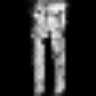

In [10]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images, fps=1)
embed.embed_file("animation.gif")

We can further improve the performance of this model with recipes like
[WGAN-GP](https://keras.io/examples/generative/wgan_gp).
Conditional generation is also widely used in many modern image generation architectures like
[VQ-GANs](https://arxiv.org/abs/2012.09841), [DALL-E](https://openai.com/blog/dall-e/),
etc.